# Inference

This notebook is to make sure anyone can do inference and produce the figures

In [1]:
import numpy as np
from astroNN.datasets import H5Loader
from astroNN.models import load_folder

# Load the dataset testing data
loader = H5Loader('__train')
loader.load_combined = False  # load individual visits
loader.load_err = False
# load the correct entry with correct order from ApogeeBCNNcensored
loader.target = ['teff', 'logg', 'C', 'C1', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'K',
                 'Ca', 'Ti', 'Ti2', 'V', 'Cr', 'Mn', 'Fe','Co', 'Ni']
x, y = loader.load()

# load RA, DEC, SNR entry
RA_visit = loader.load_entry('RA')
DEC_visit = loader.load_entry('DEC')
SNR_visit = loader.load_entry('SNR')

# Load model and do inference
bcnn = load_folder('astroNN_0617_run001')
bcnn.mc_num = 100
pred, pred_err = bcnn.test(x)

Using TensorFlow backend.


Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNNCensored
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 357.33s elapsed


In [2]:
from astropy.stats import mad_std as mad
from IPython.display import display, HTML
import pandas as pd

residue = (pred - y)

bias = np.ma.median(np.ma.array(residue, mask=[y == -9999.]), axis=0)
scatter = mad(np.ma.array(residue, mask=[y == -9999.]), axis=0)

d = {'Name': bcnn.targetname, 'Bias': [f'{bias_single:.{3}f}' for bias_single in bias], 'Scatter': [f'{scatter_single:.{3}f}' for scatter_single in scatter]}
df = pd.DataFrame(data=d)
display(HTML(df.to_html()))

,Name,Bias,Scatter
0,teff,-1.297,23.646
1,logg,0.000,0.048
2,C,-0.002,0.032
3,C1,-0.002,0.044
4,N,-0.003,0.035
5,O,-0.000,0.031
6,Na,-0.014,0.117
7,Mg,-0.002,0.023
8,Al,-0.001,0.048
9,Si,-0.002,0.025


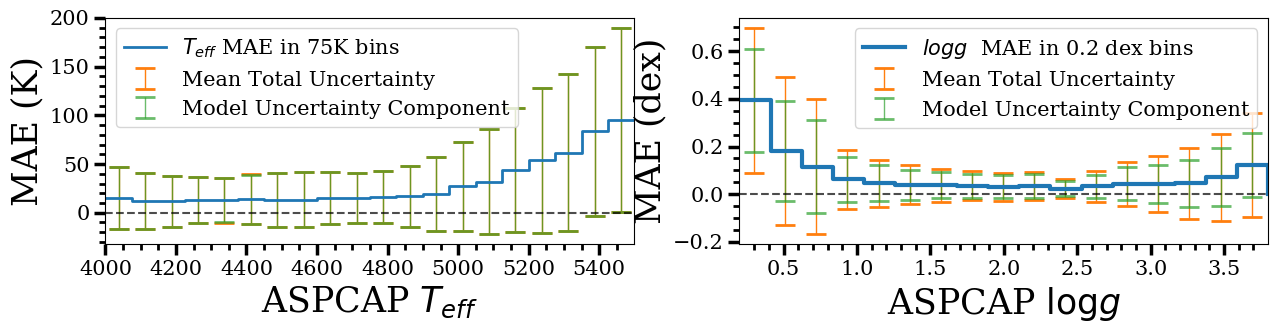

In [20]:
%matplotlib inline
import pylab as plt

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# Teff
aspcap_idx = 0
number_bin = 20
low_teff = 4000.
high_teff = 5500.
mean_abs_diff_teff = []
mean_confidence_teff = []
mean_modelconfidence_teff = []
spaces_teff = np.linspace(low_teff, high_teff, number_bin+1)

# Binning

for i in range(number_bin):
    idx = [(y[:,aspcap_idx]<spaces_teff[i+1])&(y[:,aspcap_idx]>spaces_teff[i])]
    mean_abs_diff_teff.append(np.median(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
    mean_confidence_teff.append(np.median(pred_err['total'][:, aspcap_idx][idx]))
    mean_modelconfidence_teff.append(np.median(pred_err['model'][:, aspcap_idx][idx]))

mean_abs_diff_teff.append(0.)
mean_confidence_teff.append(0.)
mean_modelconfidence_teff.append(0.)

# Log(g)
aspcap_idx = 1
number_bin = 17
low_logg = 0.2
high_logg = 3.8
mean_abs_diff_logg = []
mean_confidence_logg = []
mean_modelconfidence_logg = []
spaces_logg = np.linspace(low_logg, high_logg, number_bin+1)

# Binning
for i in range(number_bin):
    idx = [(y[:,aspcap_idx]<spaces_logg[i+1])&(y[:,aspcap_idx]>spaces_logg[i])]
    mean_abs_diff_logg.append(np.median(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
    mean_confidence_logg.append(np.median(pred_err['total'][:, aspcap_idx][idx]))
    mean_modelconfidence_logg.append(np.median(pred_err['model'][:, aspcap_idx][idx]))

mean_abs_diff_logg.append(0.)
mean_confidence_logg.append(0.)
mean_modelconfidence_logg.append(0.)

# setup plots
f, ax = plt.subplots(1, 2,figsize=(15, 3), dpi=100)

ax[0].plot(spaces_teff, mean_abs_diff_teff, ls='steps-post', linewidth=2., label='$T_{eff}$' + ' MAE in 75K bins')
ax[0].errorbar(spaces_teff+37.5, mean_abs_diff_teff, yerr=mean_confidence_teff, linestyle='None', capsize=7, 
               elinewidth=1., capthick=2., label='Mean Total Uncertainty')
ax[0].errorbar(spaces_teff+37.5, mean_abs_diff_teff, yerr=mean_modelconfidence_teff, linestyle='None', capsize=7, 
               elinewidth=1., capthick=2., alpha=0.7, label='Model Uncertainty Component')
ax[0].set_xlabel('ASPCAP ' +"$T_{eff}$", fontsize=25)
ax[0].set_ylabel('MAE (K)', fontsize=25)
ax[0].set_xlim((low_teff, high_teff-2))
ax[0].axhline(0, ls='--', c='k', alpha=0.7)
ax[0].legend(loc='best', fontsize=15)
ax[0].minorticks_on()
ax[0].tick_params(labelsize=15, width=2.5, length=8, which='major')
ax[0].tick_params(width=2, length=4, which='minor')

ax[1].plot(spaces_logg, mean_abs_diff_logg, ls='steps-post', linewidth=3., label='$log{g}$' + '  MAE in 0.2 dex bins')
ax[1].errorbar(spaces_logg+0.1, mean_abs_diff_logg, yerr=mean_confidence_logg, linestyle='None', capsize=7, 
               elinewidth=1., capthick=2., label='Mean Total Uncertainty')
ax[1].errorbar(spaces_logg+0.1, mean_abs_diff_logg, yerr=mean_modelconfidence_logg, linestyle='None', capsize=7, 
               elinewidth=1., capthick=2., alpha=0.7, label='Model Uncertainty Component')
ax[1].set_xlabel('ASPCAP ' +"$\log{g}$", fontsize=25)
ax[1].set_ylabel('MAE (dex)', fontsize=25)
ax[1].set_xlim((low_logg, high_logg-0.001))
ax[1].axhline(0, ls='--', c='k', alpha=0.7)
ax[1].minorticks_on()
ax[1].legend(loc='best', fontsize=15)
ax[1].tick_params(labelsize=15, width=2.5, length=8, which='major')
ax[1].tick_params(width=2, length=4, which='minor')

# f.tight_layout()
f.savefig('delta_teff_logg.png')

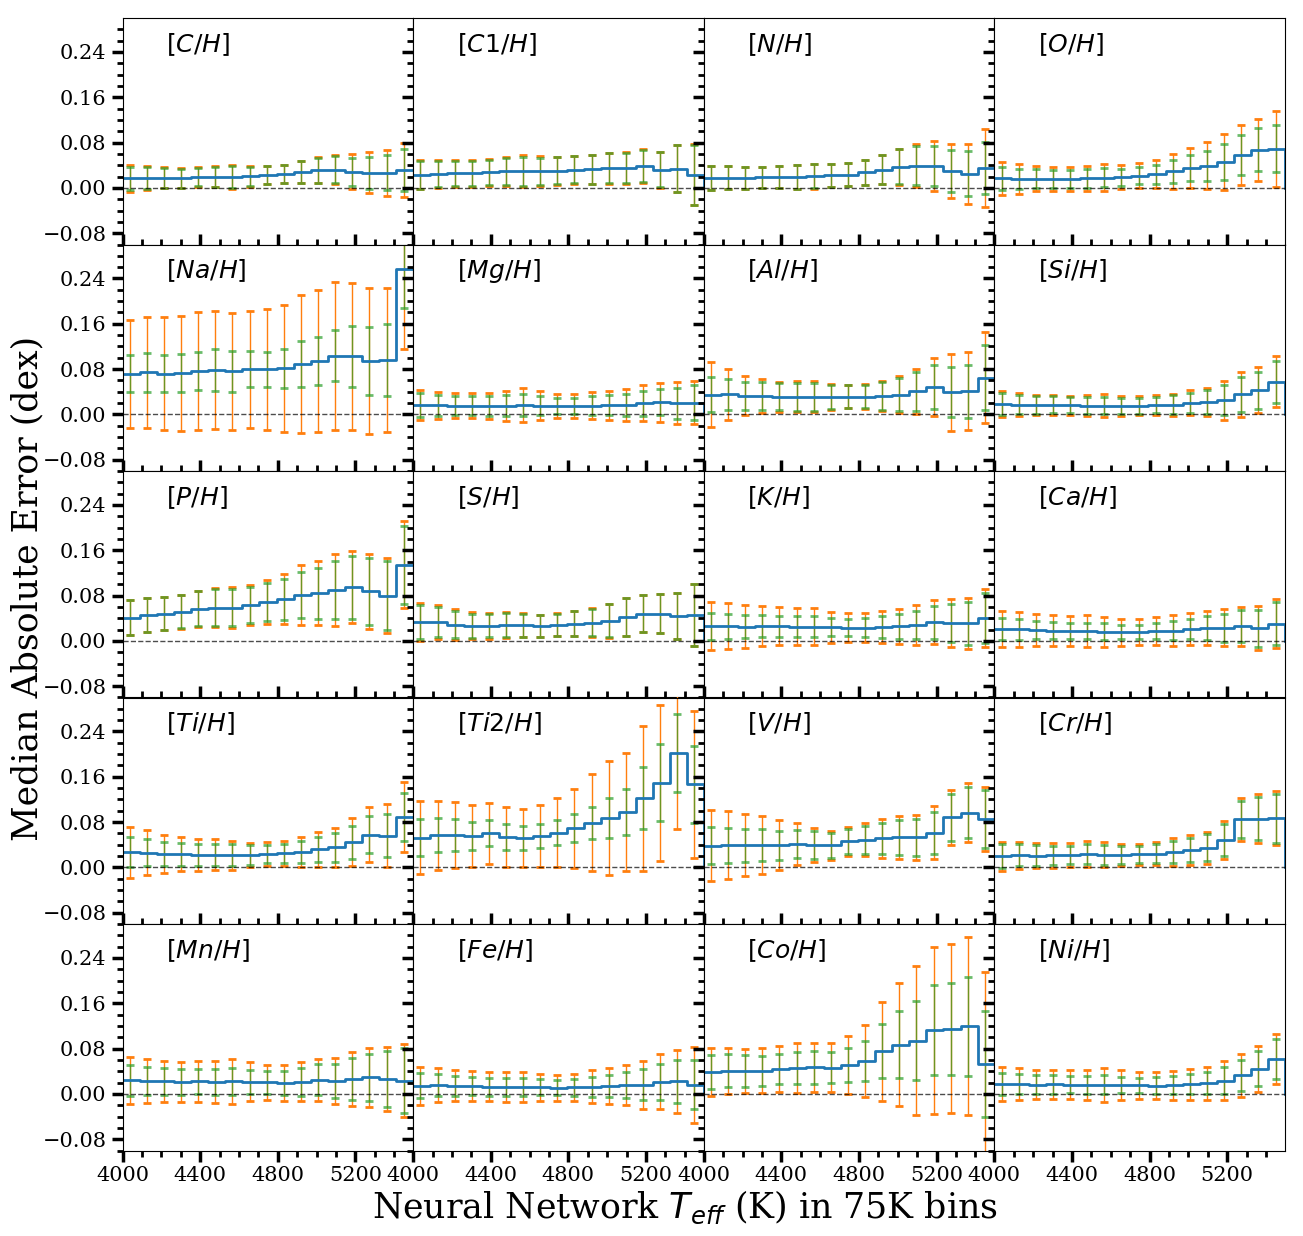

In [21]:
%matplotlib inline
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter
from astroNN.nn.numpy import median_absolute_error
plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# basic parameters
aspcap_idx = 2
number_bin = 17
low_x = -2.6
high_x = 0.8
mean_abs_diff_x = []
mean_confidence_x = []
spaces_teff_x = np.linspace(low_teff, high_teff, number_bin+1)

# setup plots
f, ax = plt.subplots(5,4,figsize=(15,15), dpi=100, sharex=True, sharey=False)

xmajorLocator = MultipleLocator(400)
ymajorLocator = MultipleLocator(0.08)

aspcap_idx = 2

for i in range(5):
    for j in range(4):
        mean_abs_diff_x = []
        mean_confidence_x = []
        mean_modelconfidence_x = []
        if aspcap_idx > 22:
            aspcap_idx = 22
        
        for ii in range(number_bin):
            idx = [(pred[:,0]<spaces_teff_x[ii+1])&(pred[:,0]>spaces_teff_x[ii])]
            mean_abs_diff_x.append(median_absolute_error(pred[:, aspcap_idx][idx], y[:,aspcap_idx][idx]))
            mean_confidence_x.append(np.median(pred_err['total'][:, aspcap_idx][idx]))
            mean_modelconfidence_x.append(np.median(pred_err['model'][:, aspcap_idx][idx]))

        mean_abs_diff_x.append(0.)
        mean_confidence_x.append(0.)
        mean_modelconfidence_x.append(0.)
        
        ax[i,j].plot(spaces_teff_x, mean_abs_diff_x, ls='steps-post', linewidth=2., label='$T_{eff}$')
        ax[i,j].errorbar(spaces_teff_x+37.5, mean_abs_diff_x, yerr=mean_confidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2.)
        ax[i,j].errorbar(spaces_teff_x+37.5, mean_abs_diff_x, yerr=mean_modelconfidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2., alpha=0.7)
        ax[i,j].set_xlim((low_teff, high_teff-2))
        ax[i,j].set_ylim((-0.1, 0.3))
        ax[i,j].axhline(0, ls='--', c='k', lw=1., alpha=0.7)
        ax[i,j].annotate(f"$[{bcnn.targetname[aspcap_idx]}/H]$", xy=(0.15,0.85),xycoords='axes fraction', fontsize=18)
        if j == 0:
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        else:
            ax[i,j].yaxis.set_major_formatter(NullFormatter())
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        if i == 4:
            ax[i,j].xaxis.set_major_locator(xmajorLocator)
        else:
            ax[i,j].xaxis.set_tick_params(direction='in', which='both')
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(labelsize=15, width=2.5, length=8, which='major')
        ax[i,j].tick_params(width=2, length=4, which='minor')
        aspcap_idx += 1
f.text(0.5,0.08,'Neural Network ' + "$T_{eff}$" + " " + "(K) in 75K bins", fontdict={'fontsize':25}, ha='center')
f.text(0.05,0.5,"Median Absolute Error (dex)",fontdict={'fontsize':25},rotation=90, va='center')
f.subplots_adjust(wspace=0,hspace=0)
f.savefig('delta_xh_teff.png')

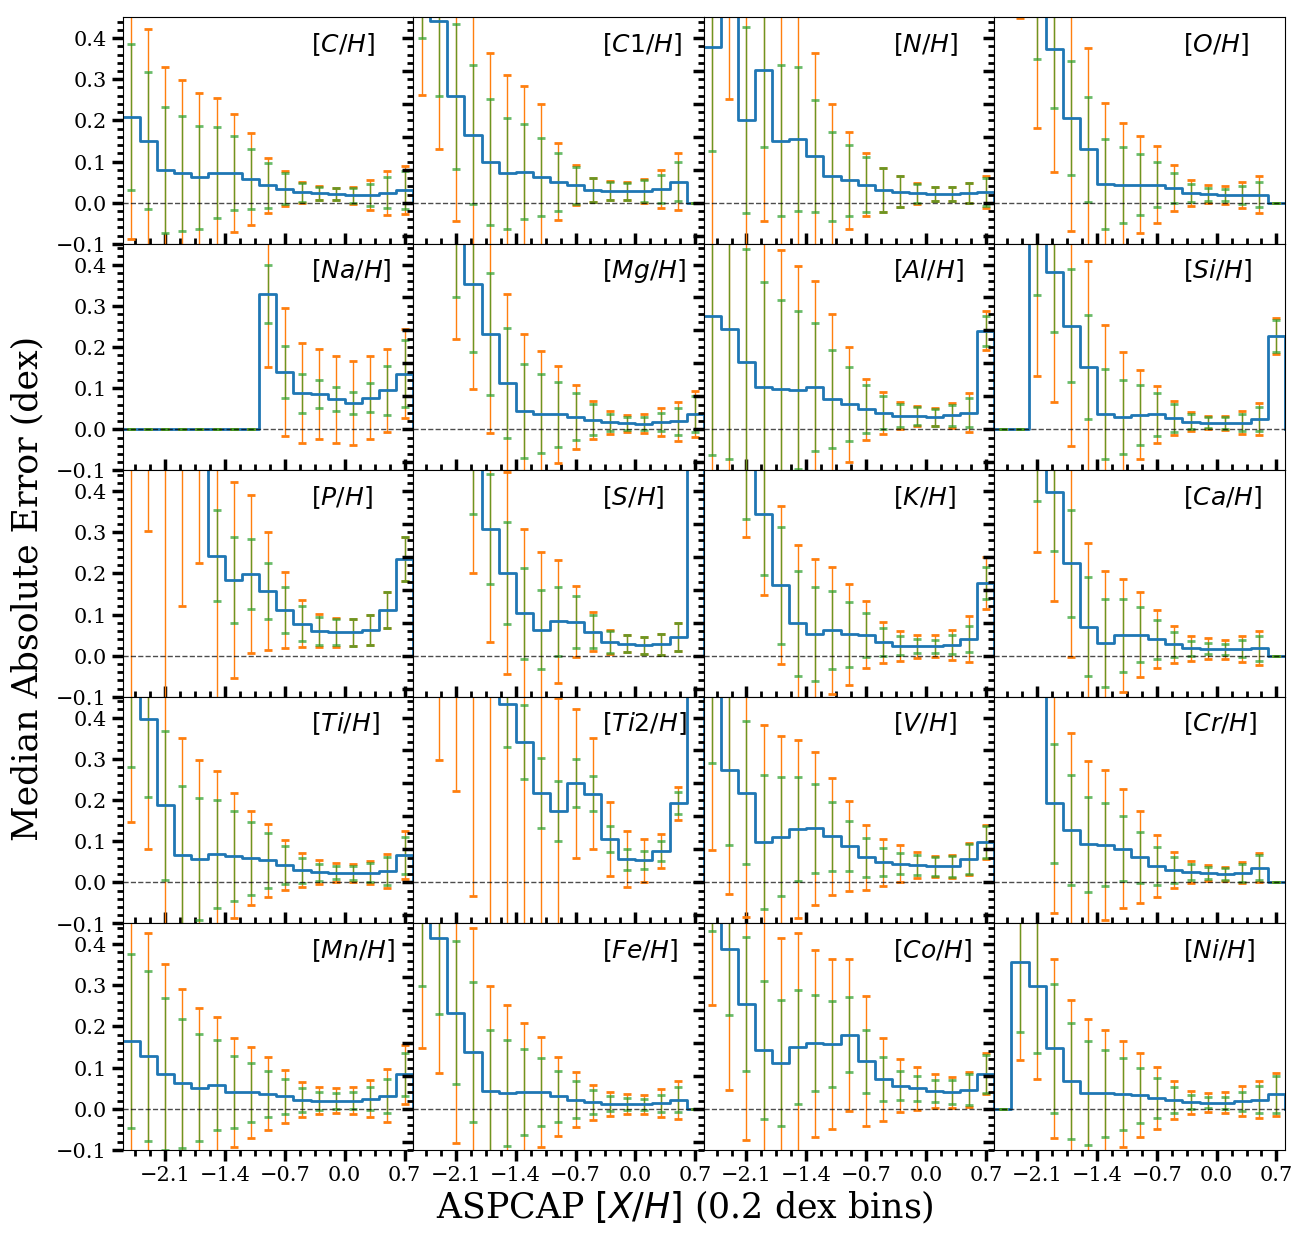

In [18]:
%matplotlib inline
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# basic parameters
number_bin = 17
low_x = -2.6
high_x = 0.8
mean_abs_diff_x = []
mean_confidence_x = []
spaces_x = np.linspace(low_x, high_x, number_bin+1)

# setup plots
f, ax = plt.subplots(5,4,figsize=(15,15), dpi=100, sharex=True, sharey=False)

xmajorLocator = MultipleLocator(0.7)
ymajorLocator = MultipleLocator(0.08)

aspcap_idx = 2

for i in range(5):
    for j in range(4):
        mean_abs_diff_x = []
        mean_confidence_x = []
        mean_modelconfidence_x = []
        if aspcap_idx > 22:
            aspcap_idx = 22
        
        for ii in range(number_bin):
            idx = [(y[:,aspcap_idx]<spaces_x[ii+1])&(y[:,aspcap_idx]>spaces_x[ii])]
            if np.sum(idx) != 0:
                mean_abs_diff_x.append(np.median(np.abs(pred[:, aspcap_idx][idx] - y[:,aspcap_idx][idx])))
                mean_confidence_x.append(np.median(pred_err['total'][:, aspcap_idx][idx]))
                mean_modelconfidence_x.append(np.median(pred_err['model'][:, aspcap_idx][idx]))
            else:
                mean_abs_diff_x.append(0.)
                mean_confidence_x.append(0.)
                mean_modelconfidence_x.append(0.)

        mean_abs_diff_x.append(0.)
        mean_confidence_x.append(0.)
        mean_modelconfidence_x.append(0.)
        
        ax[i,j].plot(spaces_x, mean_abs_diff_x, ls='steps-post', linewidth=2., label='$T_{eff}$')
        ax[i,j].errorbar(spaces_x+0.1, mean_abs_diff_x, yerr=mean_confidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2.)
        ax[i,j].errorbar(spaces_x+0.1, mean_abs_diff_x, yerr=mean_modelconfidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2., alpha=0.7)
        ax[i,j].set_xlim((low_x, high_x))
        ax[i,j].set_ylim((-0.1, 0.45))
        ax[i,j].axhline(0, ls='--', c='k', lw=1., alpha=0.7)
        ax[i,j].annotate(f"$[{bcnn.targetname[aspcap_idx]}/H]$", xy=(0.65,0.85),xycoords='axes fraction', fontsize=18)
        if j == 0:
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
            ax[i,j].set_yticks(np.arange(-0.1, 0.45, 0.1))
        else:
            ax[i,j].yaxis.set_major_formatter(NullFormatter())
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        if i == 4:
            ax[i,j].xaxis.set_major_locator(xmajorLocator)
        else:
            ax[i,j].xaxis.set_tick_params(direction='in', which='both')
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(labelsize=15, width=2.5, length=8, which='major')
        ax[i,j].tick_params(width=2, length=4, which='minor')
        aspcap_idx += 1
        
f.text(0.5,0.08,"ASPCAP "+"$[X/H]$" + " (0.2 dex bins)",fontdict={'fontsize':25}, ha='center')
f.text(0.05,0.5,"Median Absolute Error (dex)",fontdict={'fontsize':25},rotation=90, va='center')
f.subplots_adjust(wspace=0,hspace=0)
f.savefig('delta_xh.png')

# Inference at different SNR to test Neural Network Performance

First load the combined spectra and corresponding RA, DEC and SNR so we can cross-match to individual visits

In [2]:
import numpy as np
from astroNN.datasets import H5Loader
from astroNN.models import load_folder

# Load the dataset testing data
loader2 = H5Loader('__train')
loader2.load_combined = True  # load combine visits
loader2.load_err = False
# load the correct entry with correct order from ApogeeBCNNcensored
loader2.target = ['teff', 'logg', 'C', 'C1', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'K',
                  'Ca', 'Ti', 'Ti2', 'V', 'Cr', 'Mn', 'Fe','Co', 'Ni']
x_combined, y_combined = loader2.load()

# load RA, DEC, SNR entry
RA_combined = loader2.load_entry('RA')
DEC_combined = loader2.load_entry('DEC')
SNR_combined = loader2.load_entry('SNR')

pred_combined, pred_combined_err = bcnn.test(x_combined)

Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 127.04s elapsed


### Cross Matching Individual Spectra Prediction and Combined Spectra Prediction to see the effect of SNR

We want to know the neural network prediction difference between high SNR and corresponding low SNR individual spectra

In [3]:
from astroNN.datasets import xmatch

idx_1, idx_2, sep = xmatch(RA_visit, RA_combined, colRA1=RA_visit, colDec1=DEC_visit, colRA2=RA_combined, colDec2=DEC_combined)

# Absolute Difference between combined and individual visit
abs_diff = np.abs(pred[idx_1] - pred_combined[idx_2])

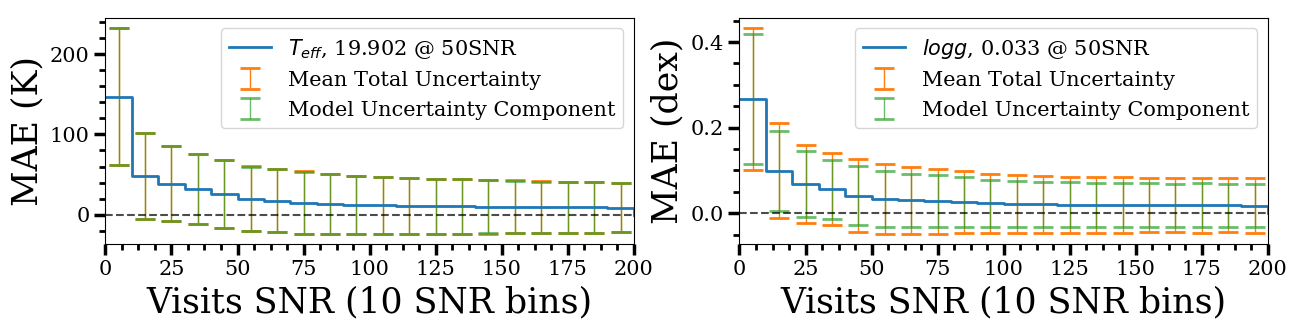

In [16]:
%matplotlib inline
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# Teff
aspcap_idx = 0
number_bin = 20
low_SNR = 0.
high_SNR = 200.
mean_abs_diff_teff = []
mean_confidence_teff = []
mean_modelconfidence_teff = []
spaces_SNR = np.linspace(low_SNR, high_SNR, number_bin+1)

# Binning

for i in range(number_bin):
    idx = [(SNR_visit[idx_1]<spaces_SNR[i+1])&(SNR_visit[idx_1]>spaces_SNR[i])]
    mean_abs_diff_teff.append(np.median(abs_diff[:,aspcap_idx][idx]))
    mean_confidence_teff.append(np.mean(pred_err['total'][:, aspcap_idx][idx_1][idx]))
    mean_modelconfidence_teff.append(np.mean(pred_err['model'][:, aspcap_idx][idx_1][idx]))


mean_abs_diff_teff.append(0.)
mean_confidence_teff.append(0.)
mean_modelconfidence_teff.append(0.)

# Log(g)
aspcap_idx = 1
number_bin = 20
mean_abs_diff_logg = []
mean_confidence_logg = []
mean_modelconfidence_logg = []

# Binning
for i in range(number_bin):
    idx = [(SNR_visit[idx_1]<spaces_SNR[i+1])&(SNR_visit[idx_1]>spaces_SNR[i])]
    mean_abs_diff_logg.append(np.median(abs_diff[:,aspcap_idx][idx_1][idx]))
    mean_confidence_logg.append(np.median(pred_err['total'][:, aspcap_idx][idx_1][idx]))
    mean_modelconfidence_logg.append(np.median(pred_err['model'][:, aspcap_idx][idx_1][idx]))

mean_abs_diff_logg.append(0.)
mean_confidence_logg.append(0.)
mean_modelconfidence_logg.append(0.)

# setup plots
f, ax = plt.subplots(1, 2,figsize=(15, 3), dpi=100)

ax[0].plot(spaces_SNR, mean_abs_diff_teff, ls='steps-post', linewidth=2., label='$T_{eff}$, ' + f'{mean_abs_diff_teff[5]:.{3}f} @ 50SNR')
ax[0].errorbar(spaces_SNR+5, mean_abs_diff_teff, yerr=mean_confidence_teff, linestyle='None', capsize=7, 
               elinewidth=1., capthick=2., label='Mean Total Uncertainty')
ax[0].errorbar(spaces_SNR+5, mean_abs_diff_teff, yerr=mean_modelconfidence_teff, linestyle='None', capsize=7, 
               elinewidth=1., capthick=2., alpha=0.7, label='Model Uncertainty Component')
ax[0].set_xlabel('Visits SNR (10 SNR bins)', fontsize=25)
ax[0].set_ylabel('MAE (K)', fontsize=25)
ax[0].set_xlim((low_SNR, high_SNR))
ax[0].axhline(0, ls='--', c='k', alpha=0.7)
ax[0].legend(loc='best', fontsize=15)
ax[0].minorticks_on()
ax[0].tick_params(labelsize=15, width=2.5, length=8, which='major')
ax[0].tick_params(width=2, length=4, which='minor')

ax[1].plot(spaces_SNR, mean_abs_diff_logg, ls='steps-post', linewidth=2., label='$log{g}$, ' + f'{mean_abs_diff_logg[5]:.{3}f} @ 50SNR')
ax[1].errorbar(spaces_SNR+5, mean_abs_diff_logg, yerr=mean_confidence_logg, linestyle='None', capsize=7, 
               elinewidth=1., capthick=2., label='Mean Total Uncertainty')
ax[1].errorbar(spaces_SNR+5, mean_abs_diff_logg, yerr=mean_modelconfidence_logg, linestyle='None', capsize=7, 
               elinewidth=1., capthick=2., alpha=0.7, label='Model Uncertainty Component')
ax[1].set_xlabel('Visits SNR (10 SNR bins)', fontsize=25)
ax[1].set_ylabel('MAE (dex)', fontsize=25)
ax[1].set_xlim((low_SNR, high_SNR))
ax[1].axhline(0, ls='--', c='k', alpha=0.7)
ax[1].legend(loc='best', fontsize=15)
ax[1].minorticks_on()
ax[1].tick_params(labelsize=15, width=2.5, length=8, which='major')
ax[1].tick_params(width=2, length=4, which='minor')

# f.tight_layout()
f.savefig('delta_SNR_teff_logg.png')

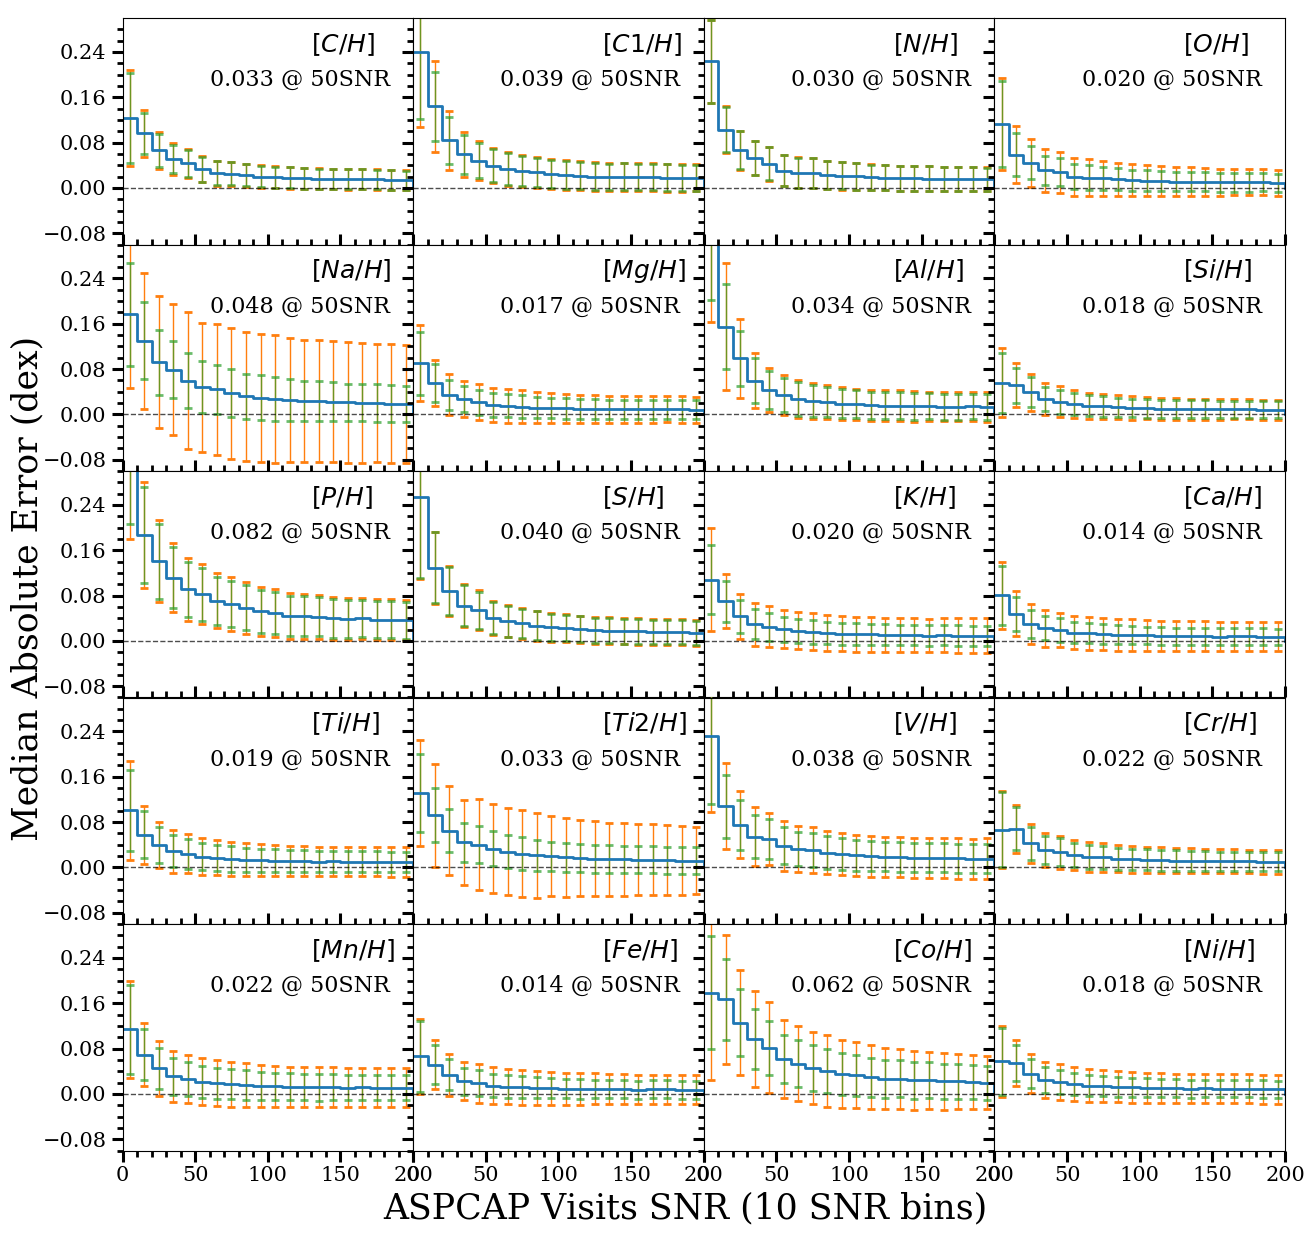

In [15]:
%matplotlib inline
import pylab as plt
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

# basic parameters
aspcap_idx = 2
number_bin = 20
mean_abs_diff_x = []
mean_confidence_x = []
low_SNR = 0.
high_SNR = 200.
spaces_SNR = np.linspace(low_SNR, high_SNR, number_bin+1)
# setup plots
f, ax = plt.subplots(5,4,figsize=(15,15), dpi=100, sharex=True, sharey=False)

xmajorLocator = MultipleLocator(50)
ymajorLocator = MultipleLocator(0.08)

for i in range(5):
    for j in range(4):
        mean_abs_diff_x = []
        mean_confidence_x = []
        mean_modelconfidence_x = []
        if aspcap_idx > 22:
            aspcap_idx = 22
        
        for ii in range(number_bin):            
            idx = [(SNR_visit[idx_1]<spaces_SNR[ii+1])&(SNR_visit[idx_1]>spaces_SNR[ii])]
            mean_abs_diff_x.append(np.median(abs_diff[:,aspcap_idx][idx_1][idx]))
            mean_confidence_x.append(np.median(pred_err['total'][:, aspcap_idx][idx_1][idx]))
            mean_modelconfidence_x.append(np.median(pred_err['model'][:, aspcap_idx][idx_1][idx]))

        mean_abs_diff_x.append(0.)
        mean_confidence_x.append(0.)
        mean_modelconfidence_x.append(0.)
        
        ax[i,j].plot(spaces_SNR, mean_abs_diff_x, ls='steps-post', linewidth=2., label='$T_{eff}$')
        ax[i,j].errorbar(spaces_SNR+5, mean_abs_diff_x, yerr=mean_confidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2.)
        ax[i,j].errorbar(spaces_SNR+5, mean_abs_diff_x, yerr=mean_modelconfidence_x, linestyle='None', capsize=3, elinewidth=1., capthick=2., alpha=0.7)
        ax[i,j].set_xlim((low_SNR, high_SNR))
        ax[i,j].set_ylim((-0.1, 0.3))
        ax[i,j].axhline(0, ls='--', c='k', lw=1., alpha=0.7)
        ax[i,j].annotate(f"$[{bcnn.targetname[aspcap_idx]}/H]$", xy=(0.65,0.85),xycoords='axes fraction', fontsize=18)
        ax[i,j].annotate(f"{mean_abs_diff_x[5]:.{3}f} @ 50SNR", xy=(0.30,0.70),xycoords='axes fraction', fontsize=16)
        if j == 0:
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        else:
            ax[i,j].yaxis.set_major_formatter(NullFormatter())
            ax[i,j].yaxis.set_major_locator(ymajorLocator)
        if i == 4:
            ax[i,j].xaxis.set_major_locator(xmajorLocator)
        else:
            ax[i,j].xaxis.set_tick_params(direction='in', which='both')
        ax[i,j].minorticks_on()
        ax[i,j].tick_params(labelsize=15, width=2.2, length=8, which='major')
        ax[i,j].tick_params(width=2, length=4, which='minor')
        aspcap_idx += 1
        
f.text(0.5,0.08,"ASPCAP Visits SNR (10 SNR bins)",fontdict={'fontsize':25}, ha='center')
f.text(0.05,0.5,"Median Absolute Error (dex)",fontdict={'fontsize':25},rotation=90, va='center')
f.subplots_adjust(wspace=0,hspace=0)
f.savefig('delta_SNR_XH.png')